Found 2841 images belonging to 5 classes.
Found 708 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 patch_extract_9 (PatchExtr  (None, None, 48)             0         ['input_10[0][0]']            
 act)                                                                                             
                                                                                                  
 patch_embedding_9 (PatchEm  (None, 256, 64)              19520     ['patch_extract_9[0][0]']     
 bedding)                                                          

Output shape: (1, 5)
Epoch 1/50
44/44 [==============================] - 51s 1s/step - loss: 1.5927 - accuracy: 0.4555 - val_loss: 1.1739 - val_accuracy: 0.5639
Epoch 2/50
44/44 [==============================] - 48s 1s/step - loss: 0.9210 - accuracy: 0.6460 - val_loss: 1.2752 - val_accuracy: 0.6491
Epoch 3/50
44/44 [==============================] - 48s 1s/step - loss: 0.7775 - accuracy: 0.7018 - val_loss: 1.4635 - val_accuracy: 0.6761
Epoch 4/50
44/44 [==============================] - 46s 1s/step - loss: 0.6501 - accuracy: 0.7526 - val_loss: 1.2455 - val_accuracy: 0.6790
Epoch 5/50
44/44 [==============================] - 47s 1s/step - loss: 0.5177 - accuracy: 0.8160 - val_loss: 1.4275 - val_accuracy: 0.6918
Epoch 6/50
44/44 [==============================] - 46s 1s/step - loss: 0.5082 - accuracy: 0.8149 - val_loss: 1.7505 - val_accuracy: 0.6179
Epoch 7/50
44/44 [==============================] - 50s 1s/step - loss: 0.4237 - accuracy: 0.8516 - val_loss: 1.2069 - val_accuracy: 0.7216

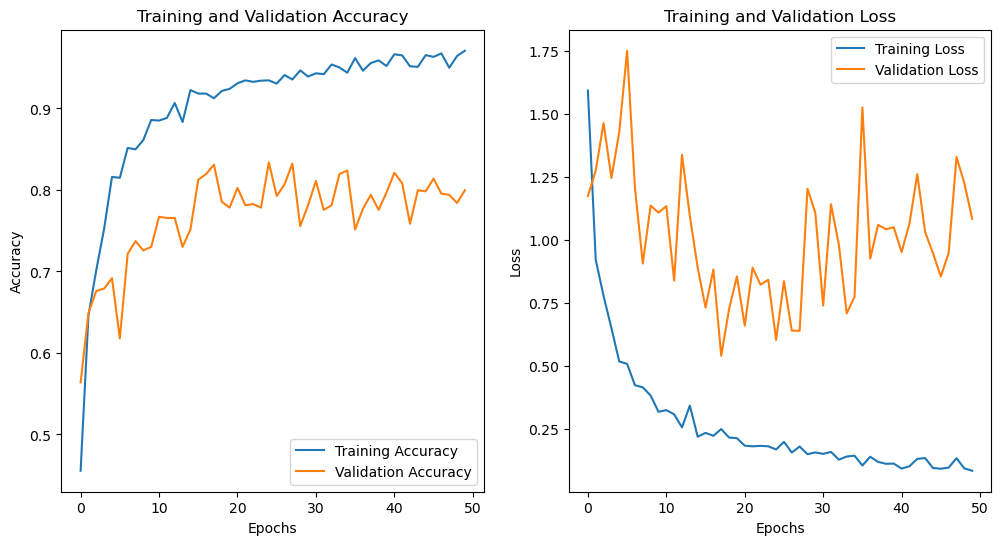

In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
    LayerNormalization,
    Dense,
    GlobalAveragePooling1D,
    Dropout,
    MultiHeadAttention,
    Reshape,
    Lambda,
    Dense,
    Softmax,
    Flatten,
)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Define directories
train_dir = '/Users/sagnik/Downloads/SingleCellPAP/Training'
test_dir = '/Users/sagnik/Downloads/SingleCellPAP/Test'

# Image dimensions and batch size
img_width, img_height = 64, 64
num_classes = 5
batch_size = 64
num_epochs = 50

# Load and preprocess the data
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

# Define the model architecture
def external_attention(x, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0):
    _, num_patch, channel = x.shape
    assert dim % num_heads == 0
    num_heads = num_heads * dim_coefficient

    x = Dense(dim * dim_coefficient)(x)
    x = Reshape((-1, num_heads, dim * dim_coefficient // num_heads))(x)
    x = tf.transpose(x, [0, 2, 1, 3])
    attn = Dense(dim // dim_coefficient)(x)
    attn = Softmax(axis=2)(attn)
    attn = Lambda(lambda attn: attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True)))(attn)
    attn = Dropout(attention_dropout)(attn)
    x = Dense(dim * dim_coefficient // num_heads)(attn)
    x = tf.transpose(x, [0, 2, 1, 3])
    x = Reshape((-1, dim * dim_coefficient))(x)
    x = Dense(dim)(x)
    x = Dropout(projection_dropout)(x)
    return x

def mlp(x, embedding_dim, mlp_dim, drop_rate=0.2):
    x = Dense(mlp_dim, activation='gelu')(x)
    x = Dropout(drop_rate)(x)
    x = Dense(embedding_dim)(x)
    x = Dropout(drop_rate)(x)
    return x

def transformer_encoder(x, embedding_dim, mlp_dim, num_heads, dim_coefficient, attention_dropout, projection_dropout):
    residual_1 = x
    x = LayerNormalization(epsilon=1e-5)(x)
    x = external_attention(
        x,
        embedding_dim,
        num_heads,
        dim_coefficient,
        attention_dropout,
        projection_dropout
    )
    x = tf.keras.layers.Add()([x, residual_1])
    residual_2 = x
    x = LayerNormalization(epsilon=1e-5)(x)
    x = mlp(x, embedding_dim, mlp_dim)
    x = tf.keras.layers.Add()([x, residual_2])
    return x

def get_model():
    inputs = tf.keras.Input(shape=(img_width, img_height, 3))
    x = inputs
    x = PatchExtract(4)(x)
    x = PatchEmbedding(256, 64)(x)
    for _ in range(8):
        x = transformer_encoder(
            x,
            64,
            256,
            8,
            4,
            0.2,
            0.2
        )
    x = GlobalAveragePooling1D()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)
    return model

# Define custom layers
class PatchExtract(tf.keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        batch_size = tf.shape(patches)[0]
        return tf.reshape(
            patches,
            shape=(batch_size, -1, self.patch_size * self.patch_size * 3)
        )

class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.embed_dim = embed_dim
        self.proj = tf.keras.layers.Dense(embed_dim)
        self.pos_embed = tf.keras.layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patch, delta=1)
        positions = tf.expand_dims(positions, axis=0)  # Add batch dimension
        positions = tf.tile(positions, [tf.shape(patch)[0], 1])  # Tile positions for each sample in the batch
        proj_output = self.proj(patch)
        pos_embed_output = self.pos_embed(positions)
        return proj_output + pos_embed_output

# Create model
model = get_model()
model.summary()

# Check input shape compatibility
sample_input = tf.zeros((1, img_width, img_height, 3))
output = model(sample_input)
print("Output shape:", output.shape)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Plot training and validation curves
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
